## Repo Analysis

In [1]:
import os
import subprocess
from pathlib import Path
from typing import Dict, List, Optional, Set, Tuple
import re

import networkx as nx
from clang import cindex
from concurrent.futures import ThreadPoolExecutor

# ──────────────────── Clang init ───────────────────────────────────
_CLANG_INITIALIZED = False

def _init_clang() -> None:
    global _CLANG_INITIALIZED
    if _CLANG_INITIALIZED:
        return
    for p in [
        "/usr/lib/llvm-18/lib",
        "/usr/lib/llvm-17/lib",
        "/usr/lib/llvm-16/lib",
        "/usr/lib/llvm-15/lib",
        "/usr/lib64/llvm",
        "/usr/lib/x86_64-linux-gnu",
        "/usr/lib/llvm/lib",
    ]:
        lib = Path(p) / "libclang.so"
        if lib.exists():
            try:
                cindex.Config.set_library_file(str(lib))
                cindex.Config.set_compatibility_check(False)
                _ = cindex.Index.create()
                _CLANG_INITIALIZED = True
                print(f"✅ libclang loaded from: {lib}")
                return
            except Exception as e:
                print(f"⚠️ Failed to load {lib}: {e}")
    raise RuntimeError("libclang.so not found - install clang (libclang-dev)")

_init_clang()

# ──────────────────── Helpers ─────────────────────────────────────

def base_name_variants(name: str) -> set:
    variants = set()
    if not name:
        return variants
    variants.add(name)
    name_no_ret = name.split()[-1]
    variants.add(name_no_ret)
    no_args = re.sub(r'\(.*\)', '', name_no_ret)
    variants.add(no_args)
    base = no_args.split("::")[-1]
    variants.add(base)
    no_template = re.sub(r'<.*?>', '', base)
    variants.add(no_template)
    return {v.strip() for v in variants if v.strip()}

def is_mangled(name: str) -> bool:
    return name.startswith("_Z")

def demangle(name: str) -> str:
    if not is_mangled(name):
        return name
    try:
        out = subprocess.run(["c++filt", name], capture_output=True, text=True)
        if out.returncode == 0 and out.stdout.strip():
            return out.stdout.strip()
    except FileNotFoundError:
        pass
    return name

def fq_name(cur: cindex.Cursor) -> str:
    parts = []
    c = cur
    while c and c.kind != cindex.CursorKind.TRANSLATION_UNIT:
        if c.kind in (
            cindex.CursorKind.NAMESPACE,
            cindex.CursorKind.CLASS_DECL,
            cindex.CursorKind.STRUCT_DECL,
            cindex.CursorKind.CLASS_TEMPLATE,
        ):
            parts.append(c.spelling)
        c = c.semantic_parent
    parts.reverse()
    if cur.spelling:
        parts.append(cur.spelling)
    n = "::".join(parts)
    return demangle(n) if is_mangled(n) else n

_file_cache: Dict[str, List[str]] = {}
_visited_cursors: Set[cindex.Cursor] = set()

def read_extent(cur: cindex.Cursor) -> str:
    ext = cur.extent
    if not ext or not ext.start.file:
        return ""
    fn = ext.start.file.name
    if fn not in _file_cache:
        try:
            with open(fn, 'r', encoding='utf-8', errors='ignore') as f:
                _file_cache[fn] = f.readlines()
        except:
            _file_cache[fn] = []
    
    lines = _file_cache[fn]
    start_line = ext.start.line - 1  # 0-based index
    end_line = ext.end.line - 1      # 0-based index
    start_col = ext.start.column - 1 # 0-based index
    end_col = ext.end.column - 1     # 0-based index
    
    # Ensure we don't go out of bounds
    if start_line >= len(lines) or start_line < 0:
        return ""
    
    if start_line == end_line:
        # Single line case
        line = lines[start_line]
        return line[start_col:end_col+1] if end_col < len(line) else line[start_col:]
    else:
        # Multi-line case
        result = []
        # First line from start column to end of line
        if start_line < len(lines):
            result.append(lines[start_line][start_col:])
        
        # Middle lines (complete)
        for l in range(start_line + 1, min(end_line, len(lines))):
            result.append(lines[l])
        
        # Last line from start to end column
        if end_line < len(lines):
            line = lines[end_line]
            result.append(line[:end_col+1] if end_col < len(line) else line)
        
        return ''.join(result)

def outline_ast(cur: cindex.Cursor, depth=0) -> List[str]:
    lines = ["  " * depth + cur.kind.name]
    for c in cur.get_children():
        lines.extend(outline_ast(c, depth + 1))
    return lines

# ──────────────────── Traversal ────────────────────────────────────

CTOR_KINDS = {
    cindex.CursorKind.CONSTRUCTOR,
    cindex.CursorKind.DESTRUCTOR,
}

FUNC_KINDS = {
    cindex.CursorKind.FUNCTION_DECL,
    cindex.CursorKind.CXX_METHOD,
    cindex.CursorKind.FUNCTION_TEMPLATE,
} | CTOR_KINDS

TYPE_KINDS = {
    cindex.CursorKind.CLASS_DECL,
    cindex.CursorKind.STRUCT_DECL,
    cindex.CursorKind.CLASS_TEMPLATE,
    cindex.CursorKind.TYPEDEF_DECL,
    cindex.CursorKind.TYPE_ALIAS_DECL,
    cindex.CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
    cindex.CursorKind.ENUM_DECL,
}

TEMPLATE_PARAM_KINDS = {
    cindex.CursorKind.TEMPLATE_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
}

MEMBER_KINDS = {cindex.CursorKind.FIELD_DECL}
GLOBAL_KINDS = {cindex.CursorKind.VAR_DECL}


# ─── Helper to build fully-qualified name with signature for ctors/dtors ───
def _signature(cur: cindex.Cursor) -> str:
    # Build namespace/class qualifier chain
    parts = []
    p = cur.semantic_parent
    while p and p.kind != cindex.CursorKind.TRANSLATION_UNIT:
        if p.kind in (
            cindex.CursorKind.NAMESPACE,
            cindex.CursorKind.CLASS_DECL,
            cindex.CursorKind.STRUCT_DECL,
            cindex.CursorKind.CLASS_TEMPLATE,
        ):
            parts.append(p.spelling)
        p = p.semantic_parent
    parts.reverse()
    prefix = "::".join(parts)

    # Destructor: no args
    if cur.kind == cindex.CursorKind.DESTRUCTOR:
        base = cur.semantic_parent.spelling
        name = f"{prefix}::~{base}()"
    else:
        # Constructor: include parameter types
        base = cur.spelling  # class name
        params = ", ".join(arg.type.spelling for arg in cur.get_arguments())
        name = f"{prefix}::{base}({params})"
    return name

def loc_info(cur: cindex.Cursor) -> dict:
    loc = cur.location
    return {"file": str(loc.file) if loc.file else "", "line": loc.line, "col": loc.column}
            

# ─── Updated collect_nodes ───
def collect_nodes(cursor: cindex.Cursor, G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)
    
    # cache the file of the current cursor

    def ensure_node(name: str, kind: str, cur: Optional[cindex.Cursor]):
        if name not in G or len(G.nodes[name]['ast']) < len("\n".join(outline_ast(cur))):
            G.add_node(name, kind=kind, code="", ast="", cursor=None, **(loc_info(cur) if cur else {}))
            if cur:
                if G.nodes[name]["code"] == "":
                    G.nodes[name]["code"] = read_extent(cur)
                if G.nodes[name]["ast"] == "":
                    try:
                        G.nodes[name]["ast"] = "\n".join(outline_ast(cur))
                    except Exception:
                        G.nodes[name]["ast"] = "<AST outline unavailable>"
                if G.nodes[name]["cursor"] is None:
                    G.nodes[name]["cursor"] = cur

    # --- functions, methods, templates, constructors, destructors ---
    if cursor.kind in FUNC_KINDS and in_proj(cursor):            
        if cursor.is_definition():
            if cursor.kind in CTOR_KINDS:
                fq = _signature(cursor)
            else:
                fq = fq_name(cursor)
            ensure_node(fq, "function", cursor)
        else:
            if cursor.kind in CTOR_KINDS:
                fq = _signature(cursor)
            else:
                fq = fq_name(cursor)
            if fq not in G:
                ensure_node(fq, "function", cursor)
    
    # --- member variables ---
    if cursor.kind in MEMBER_KINDS and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "member", cursor)

    # --- global variables ---
    if cursor.kind in GLOBAL_KINDS and cursor.semantic_parent.kind == cindex.CursorKind.TRANSLATION_UNIT and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "variable", cursor)

    # --- types ---
    if cursor.kind in TYPE_KINDS and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "type", cursor)

    # recurse
    for child in cursor.get_children():
        collect_nodes(child, G, root)

def add_edge_strict(G: nx.DiGraph, u: str, v: str, **kwargs) -> None:
    if u == v:
        return
    if G.has_edge(u, v):
        return
    if not G.has_node(u):
        return
    if not G.has_node(v):
        return
    else:
        G.add_edge(u, v, **kwargs)


def collect_edges(cursor: cindex.Cursor, ctx_func: Optional[str], G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)

    # Update context if we're inside a known function or template
    if cursor.kind in FUNC_KINDS and cursor.is_definition() and in_proj(cursor):
        if cursor.kind in CTOR_KINDS:
            ctx_func = _signature(cursor)
        else:
            ctx_func = fq_name(cursor)

    if cursor.kind in TYPE_KINDS and cursor.is_definition() and in_proj(cursor):
        ctx_func = fq_name(cursor)
    
    if cursor.kind in MEMBER_KINDS and cursor.is_definition() and in_proj(cursor):
        ctx_func = fq_name(cursor)

    if cursor.kind in GLOBAL_KINDS and cursor.is_definition() and cursor.semantic_parent.kind == cindex.CursorKind.TRANSLATION_UNIT and in_proj(cursor):
        ctx_func = fq_name(cursor)

    # --- Function call detection
    if cursor.kind == cindex.CursorKind.CALL_EXPR and ctx_func:
        callee_name = None
        raw_spelling = ""

        # Direct reference to the function being called
        if cursor.referenced and cursor.referenced.kind in FUNC_KINDS:
            if cursor.referenced.kind in CTOR_KINDS:
                callee_name = _signature(cursor.referenced)
            else:
                callee_name = fq_name(cursor.referenced)
            raw_spelling = cursor.referenced.spelling or ""

        # Fallback: search for the function name in children
        if not callee_name:
            for child in cursor.get_children():
                if (
                    child.kind == cindex.CursorKind.DECL_REF_EXPR and
                    child.spelling and
                    (not child.referenced or child.referenced.kind in FUNC_KINDS)
                ):
                    raw_spelling = child.spelling
                    if child.referenced and child.referenced.kind in FUNC_KINDS:
                        callee_name = fq_name(child.referenced)
                    else:
                        variants = base_name_variants(child.spelling)
                        matches = [
                            n for n, d in G.nodes(data=True)
                            if d.get("kind") == "function" and variants & base_name_variants(n)
                        ]
                        if len(matches) == 1:
                            callee_name = matches[0]
                        elif len(matches) > 1:
                            print(f"⚠️ Ambiguous call to '{child.spelling}'; candidates: {matches}")
                        else:
                            print(f"⚠️ Could not resolve call to '{child.spelling}' from '{ctx_func}'")
                    break

        # Record call edge
        if callee_name and ctx_func != callee_name:
            loc = cursor.location
            add_edge_strict(G, ctx_func, callee_name, type="call", location=(str(loc.file), loc.line), raw=raw_spelling)

    # --- references ---
    if cursor.kind == cindex.CursorKind.DECL_REF_EXPR and ctx_func:
        ref = cursor.referenced
        if ref and in_proj(ref):
            loc = cursor.location
            if ref.kind in FUNC_KINDS:
                # function ref edge
                callee = _signature(ref) if ref.kind in CTOR_KINDS else fq_name(ref)
                if callee != ctx_func:
                    add_edge_strict(G, ctx_func, callee, type="ref", location=(str(loc.file), loc.line), raw=cursor.spelling)
            elif ref.kind in GLOBAL_KINDS:
                # global variable ref edge
                callee = fq_name(ref)
                if callee != ctx_func:
                    add_edge_strict(G, ctx_func, callee, type="global-ref", location=(str(loc.file), loc.line), raw=cursor.spelling)
    if cursor.kind == cindex.CursorKind.MEMBER_REF_EXPR and ctx_func:
            ref = cursor.referenced
            if ref and in_proj(ref):
                loc = cursor.location
                name = fq_name(ref)
                add_edge_strict(G, ctx_func, name, type="member-ref", location=(str(loc.file), loc.line), raw=cursor.spelling)
    if cursor.kind == cindex.CursorKind.NAMESPACE_REF and ctx_func:
        ref = cursor.referenced
        if ref and in_proj(ref):
            loc = cursor.location
            name = fq_name(ref)
            add_edge_strict(G, ctx_func, name, type="global-ref", location=(str(loc.file), loc.line), raw=cursor.spelling)


    # --- Type reference tracking
    if cursor.kind == cindex.CursorKind.TYPE_REF and ctx_func and in_proj(cursor):
        decl = cursor.referenced or cursor.get_definition() or cursor.get_type().get_declaration()
        if not decl:
            return
        if decl.kind in TEMPLATE_PARAM_KINDS:
            print(f"⚠️ Ignoring template parameter reference: {decl.spelling} at location {loc_info(decl)}")
            return

        if in_proj(decl):
            type_name = fq_name(decl)
            if type_name not in G:
                G.add_node(type_name, kind="type", code="", ast="", cursor=decl, **loc_info(decl))
                print(f"⚠️ Missing node for type '{type_name}'")
            loc = cursor.location
            if type_name != ctx_func:
                add_edge_strict(G, ctx_func, type_name, type="type-ref", location=(str(loc.file), loc.line))

    # Recurse into children
    for child in cursor.get_children():
        collect_edges(child, ctx_func, G, root)


# ──────────────────── Parsing helpers ──────────────────────────────

COMMON_COMPILER_ARGS = [
    '-x', 'c++', '-std=c++17',
    '-I/usr/include', '-I/usr/local/include',
    '-I.', '-Isrc', '-Iinclude', '-I..',
    '-fparse-all-comments',
    '-Wno-unknown-warning-option',
    '-ferror-limit=0',
    '-D__clang_analyzer__',
    '-ftemplate-depth=1024',
    '-finstantiate-templates',
]

def make_include_args(p: Path) -> List[str]:
    args = []
    src_dir = str(p.parent)
    args.append(f'-I{src_dir}')
    parent = p.parent.parent
    if parent.exists():
        args.append(f'-I{parent}')
        for sub in ("include","src","lib"):
            d = parent / sub
            if d.is_dir():
                args.append(f'-I{d}')
    return args

def parse_file(index: cindex.Index, p: Path) -> Optional[cindex.TranslationUnit]:
    try:
        args = COMMON_COMPILER_ARGS + make_include_args(p)
        return index.parse(str(p), args=args,
                           options=cindex.TranslationUnit.PARSE_DETAILED_PROCESSING_RECORD)
    except Exception as e:
        print(f"Error parsing {p}: {e}")
        return None

# ──────────────────── File discovery ───────────────────────────────

def generate_uber_file(project_root: Path, output_file: Path = None) -> Path:
    if output_file is None:
        output_file = project_root / "__uber.cpp"

    includes = []
    for ext in (".hpp", ".h", ".cpp", ".cxx", ".cc"):
        for file in project_root.rglob(f"*{ext}"):
            if "test" in file.parts:  # optional: skip tests
                continue
            rel_path = file.relative_to(project_root)
            includes.append(f'#include "{rel_path}"')

    content = "// AUTO-GENERATED UBER FILE\n" + "\n".join(sorted(includes)) + "\n"
    output_file.write_text(content)
    print(f"✅ Uber file generated at {output_file}")
    return output_file

def parse_uber_file(index: cindex.Index, uber_file: Path) -> Optional[cindex.TranslationUnit]:
    args = COMMON_COMPILER_ARGS + make_include_args(uber_file)
    try:
        return index.parse(str(uber_file), args=args,
                           options=cindex.TranslationUnit.PARSE_DETAILED_PROCESSING_RECORD)
    except Exception as e:
        print(f"❌ Failed to parse uber file: {e}")
        return None


def cpp_files(root: Path) -> List[Path]:
    return [Path(dp) / f for dp, _, files in os.walk(root) for f in files if f.endswith((".cpp", ".cc", ".cxx", ".c", ".hpp", ".h"))]

# ──────────────────── Build graph ─────────────────────────────────-

def build_graph(root: Path, max_threads: int = 8) -> nx.DiGraph:
    idx = cindex.Index.create()
    G = nx.DiGraph()    
    uber_file = generate_uber_file(root)
    tu = parse_uber_file(idx, uber_file)    
    collect_nodes(tu.cursor, G, root)
    print(f"Found {len(G.nodes)} nodes")
    collect_edges(tu.cursor, None, G, root)
    print(f"Found {len(G.edges)} edges")
    # Remove the uber file node
    if uber_file.name in G:
        G.remove_node(uber_file.name)
    # Delete the uber file
    try:
        os.remove(uber_file)
    except Exception as e:
        print(f"❌ Failed to remove uber file: {e}")
    return G


# ──────────────────── Notebook run ─────────────────────────────────
from utils.git_utils import clone_repo
url = 'https://github.com/adiprerepa/cs598APE-hw1'
branch = 'master'
repo = clone_repo(url, branch=branch)
working_dir = repo.working_dir
print(f"Working directory: {working_dir}")
PROJECT_DIR = Path(working_dir).resolve()

graph = build_graph(PROJECT_DIR, max_threads=8)

✅ libclang loaded from: /usr/lib/llvm-18/lib/libclang.so
Working directory: /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1
✅ Uber file generated at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/__uber.cpp
Found 217 nodes
Found 969 edges


Working directory: /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1
✅ libclang loaded from: /usr/lib/llvm-18/lib/libclang.so
✅ Uber file generated at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/__uber.cpp
Found 217 nodes
Found 969 edges
Merging node TimeAndShape into TimeAndShape::TimeAndShape
⚠️ Graph is not a DAG. Using SCC condensation for level estimation.
⚠️ Found cycles: [['Autonoma::Autonoma', 'Shape::Shape']]


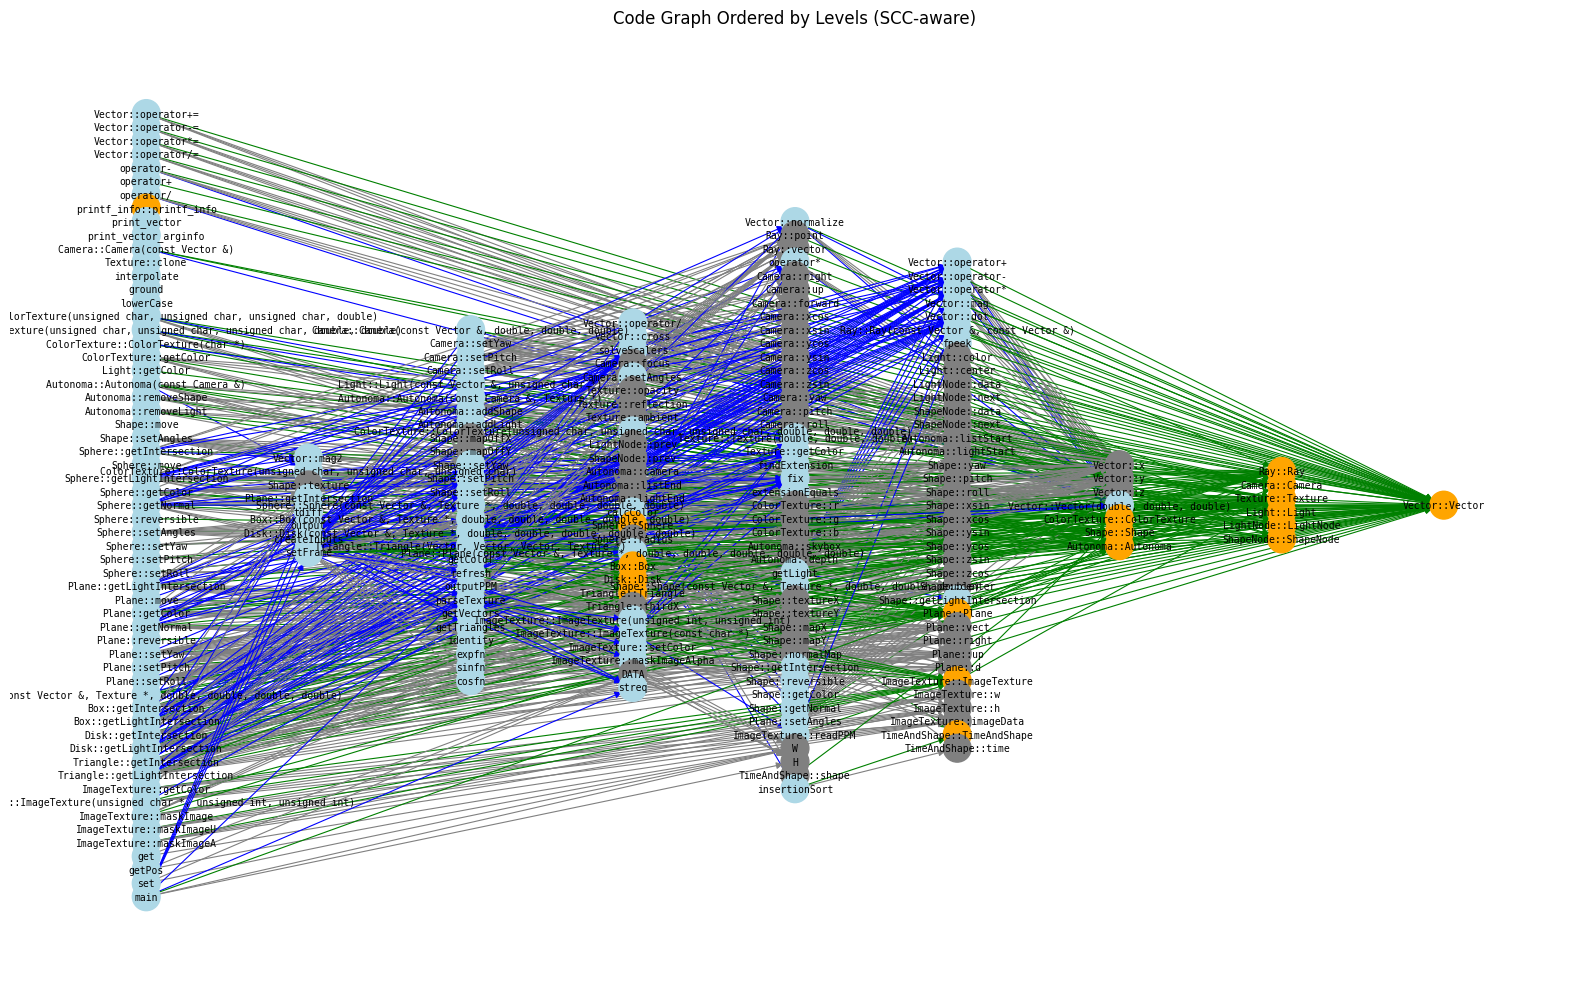

In [1]:
from utils.git_utils import clone_repo
from pathlib import Path
from analyzers.code_analyzer import CodeAnalyzer
url = 'https://github.com/adiprerepa/cs598APE-hw1'
branch = 'master'
repo = clone_repo(url, branch=branch)
working_dir = repo.working_dir
print(f"Working directory: {working_dir}")
PROJECT_DIR = Path(working_dir).resolve()

analyzer = CodeAnalyzer(PROJECT_DIR)
analyzer.plot(horizontal=True)

In [ ]:
substring = 'main'
# print the code
for node in graph.nodes:
    if node.startswith(substring):
        code = graph.nodes[node]['code']
        print(f"Code for {node}:\n{code}")
        ast = graph.nodes[node]['ast']
        print(f"AST for {node}:\n{ast}")
        cursor = graph.nodes[node]['cursor']
        # if the cursor is a constructor, check its reference
        if cursor.kind in CTOR_KINDS:
            reference = cursor.referenced
            if reference:
                print(f"Constructor {node} found at {loc_info(reference)}")
            else:
                print(f"Constructor {node} not found")
        # print the node's successors
        successors = list(graph.successors(node))
        print(f"Successors of {node}: {successors}")
        # print the node's predecessors
        predecessors = list(graph.predecessors(node))
        print(f"Predecessors of {node}: {predecessors}")
        # print the url of the file
        file = graph.nodes[node]['file']
        line = graph.nodes[node]['line']
        print(f"File: {file}:{line}")

Code for main:
int main(int argc, const char** argv){

   int frameLen = 1;
   const char* inFile = NULL;
   const char* animateFile = NULL;
   const char* outFile = NULL;
   bool toMovie = true;
   bool png = true;
   for (int i=1; i<argc; i++) {
      if (streq(argv[i], "-H")) {
         if (i + 1 >= argc) {
            printf("Error -H option must be followed by an integer height");
         }
         H = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-W")) {
         if (i + 1 >= argc) {
            printf("Error -W option must be followed by an integer width");
         }
         W = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-F")) {
         if (i + 1 >= argc) {
            printf("Error -F option must be followed by an integer number of frames");
         }
         frameLen = atoi(argv[i+1]);
         i++;
         continue;
      }
      if (streq(argv[i], "-o")) {
         if (i + 1 >= argc) {
   

In [ ]:
import subprocess
import json
import networkx as nx
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_cli_and_get_successors(codebase_dir, function_name):
    try:
        result = subprocess.run(
            ["python3", "analyzers/dependency_extractor.py", codebase_dir, function_name],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )
        output = result.stdout.strip()

        successors = set()
        inside_func = False

        for line in output.splitlines():
            stripped = line.strip()
            if stripped.startswith("Function:"):
                inside_func = True
            elif stripped.startswith("Dependencies:"):
                continue
            elif "Function calls:" in stripped:
                continue
            elif stripped.startswith("- Name:"):
                name = stripped.split(":", 1)[-1].strip()
                if name:
                    successors.add(name)

        return function_name, successors

    except Exception as e:
        print(f"⚠️ Error running CLI for {function_name}: {e}")
        return function_name, set()

def compare_graph_to_cli(graph: nx.DiGraph, codebase_dir: str, max_workers: int = 8):
    print("\n🔍 Verifying successors (parallel)...")
    non_superset = []

    function_nodes = [
        node for node, data in graph.nodes(data=True)
        if data.get("kind") == "function"
    ]

    whitelist = {
        'malloc', 'fprintf', 'free', 'fopen', 'fclose', 'fwrite', 'fread',
        'fseek', 'ftell', 'fgets', 'fputs', 'strdup', 'strcpy', 'strcat',
        'strncpy', 'strncat', 'memcpy', 'memset', 'memmove', 'strlen',
        'strchr', 'strrchr', 'strstr', 'strtok', 'strspn', 'strcspn',
        'strpbrk', 'strerror', 'strerror_r', 'strtol', 'strtoul', 'strtod',
        'strtof', 'strtoll', 'strtoull', 'strtold', 'strtoll', 'strtoull',
        'cos', 'sin', 'tan', 'acos', 'asin', 'atan', 'atan2',
        'fscanf', 'sscanf', 'vsnprintf', 'snprintf', 'strdup',
        'printf', 'calloc', 'atof', 'atoi', 'atol', 'atoll',
    }

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_func = {
            executor.submit(run_cli_and_get_successors, codebase_dir, func): func
            for func in function_nodes
        }

        for future in as_completed(future_to_func):
            func = future_to_func[future]
            cli_successors = set()
            try:
                func_name, cli_successors = future.result()
            except Exception as e:
                print(f"⚠️ Failed to get result for {func}: {e}")
                continue
            cli_successors = cli_successors - whitelist
            graph_successors = graph.successors(func)
            # constraint the successors to only those which are functions or types
            graph_successors = {n for n in graph_successors if graph.nodes[n].get("kind") in {"function", "type"}}
            # if graph succesors is not a superset of cli successors
            if not cli_successors.issubset(graph_successors):
                non_superset.append((func, graph_successors, cli_successors))
                print(f"\n❌ Mismatch for: {func}")
                print(f"  ➤ Graph: {sorted(graph_successors)}")
                print(f"  ➤ CLI  : {sorted(cli_successors)}")

    if not non_superset:
        print("\n✅ The graph is a superset of the CLI")
    else:
        print(f"\n❌ Found {len(non_superset)} non superset nodes.")

    return non_superset


print(str(PROJECT_DIR))

mismatches = compare_graph_to_cli(graph, str(PROJECT_DIR), max_workers=128)

/home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1

🔍 Verifying successors (parallel)...



❌ Mismatch for: parseTexture
  ➤ Graph: ['ColorTexture::ColorTexture', 'ColorTexture::ColorTexture(unsigned char, unsigned char, unsigned char, double, double, double)', 'ImageTexture::ImageTexture', 'ImageTexture::ImageTexture(const char *)', 'ImageTexture::ImageTexture(unsigned int, unsigned int)', 'ImageTexture::maskImageAlpha', 'ImageTexture::setColor', 'Texture::Texture', 'streq']
  ➤ CLI  : ['ColorTexture::ColorTexture', 'ImageTexture::ImageTexture', 'ImageTexture::maskImageAlpha', 'ImageTexture::setColor', 'exit', 'getline', 'streq']

❌ Mismatch for: operator+
  ➤ Graph: ['Vector::Vector']
  ➤ CLI  : ['Vector::Vector', '__builtin_addressof']

❌ Mismatch for: Disk::getIntersection
  ➤ Graph: ['Disk::Disk', 'Plane::Plane', 'Plane::getIntersection', 'Ray::Ray', 'Vector::Vector', 'Vector::operator*', 'Vector::operator+', 'Vector::operator-', 'solveScalers']
  ➤ CLI  : ['Plane::getIntersection', 'Ray::Ray', 'Vector::Vector', 'Vector::operator*', 'Vector::operator+', 'Vector::operato

In [ ]:
import re

print("\n--- Nodes with degree 0 --- that may not deserve it")

whitelist = {'min', 'max', 'empty', 'size', 'full', 'pop', 'operator()', 'push'}

for n in graph.nodes:
    token = n.split("::")[-1]
    if token in whitelist: continue
    if graph.degree(n) == 0:
        # get the bare function name (no namespaces)
        
        # build a regex that:
        #  - won’t match inside larger identifiers
        #  - won’t match parts of a namespace like “My::foo” inside “My::foobar”
        # (?<![\w:])  = not preceded by a word‑char or colon
        # (?![\w])    = not followed by a word‑char
        pat = re.compile(r"(?<![\w:])" + re.escape(token) + r"(?![\w])")
        
        for m in graph.nodes:
            if m == n:
                continue

            code = graph.nodes[m]["code"]
            for match in pat.finditer(code):
                print("=========")
                print(f"Node {n} is referenced in {m}:")
                # location info
                loc_n = graph.nodes[n]
                loc_m = graph.nodes[m]
                print(f"  {n} defined at {loc_n['file']}:{loc_n['line']}")
                print(f"  {m} defined at {loc_m['file']}:{loc_m['line']}")
                
                # show the snippet around the match
                start, end = match.span()
                snippet = code[max(0, start-30):min(len(code), end+30)]
                # highlight the match with brackets
                highlighted = snippet.replace(
                    snippet[start - max(0, start-30): end - max(0, start-30)],
                    f"[{token}]"
                )
                print("  code context:", highlighted)
                
                # optionally print full code+AST if you still need it
                print(graph.nodes[m]['code'])
                print("==========\n")
                # once we’ve found one match, we can stop scanning this m
                break



--- Nodes with degree 0 --- that may not deserve it
Node printf_info::printf_info is referenced in print_vector:
  printf_info::printf_info defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  print_vector defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  code context: or(FILE *stream, const struct [printf_info] *info, const void 
*const *ar
int print_vector(FILE *stream, const struct printf_info *info, const void 
*const *args);

Node printf_info::printf_info is referenced in print_vector_arginfo:
  printf_info::printf_info defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:82
  print_vector_arginfo defined at /home/ayuram/pesquared/tmp/adiprerepa/cs598APE-hw1/src/vector.h:85
  code context: _vector_arginfo (const struct [printf_info] *info, size_t n, int 
*argtyp
int print_vector_arginfo (const struct printf_info *info, size_t n, int 
*argtypes);

Node Texture::clone is referenced in Texture::Texture:
 

## Obfuscation

In [ ]:
import hashlib
import os
import re
from pathlib import Path
from typing import Dict, Set, List

from clang import cindex
from clang.cindex import CursorKind

from utils.string_utils import remove_comments, word_list


class Obfuscator:
    _word_pat_cache: Dict[frozenset, re.Pattern] = {}

    _CURSOR_KINDS_BY_TIER: Dict[int, Set[CursorKind]] = {
        2: {  # Variable names (user-defined)
            CursorKind.VAR_DECL,
            CursorKind.PARM_DECL,
            CursorKind.FIELD_DECL,
            CursorKind.ENUM_CONSTANT_DECL,
            CursorKind.MACRO_INSTANTIATION,
            CursorKind.MACRO_DEFINITION,
            CursorKind.MEMBER_REF_EXPR,
            CursorKind.DECL_REF_EXPR,
        },
        3: {  # Add user-defined functions & class names
            CursorKind.FUNCTION_DECL,
            CursorKind.CXX_METHOD,
            CursorKind.FUNCTION_TEMPLATE,
            CursorKind.STRUCT_DECL,
            CursorKind.CLASS_DECL,
            CursorKind.CLASS_TEMPLATE,
            CursorKind.TYPEDEF_DECL,
            CursorKind.TYPE_ALIAS_DECL,
            CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
            CursorKind.ENUM_DECL,
            CursorKind.TEMPLATE_TYPE_PARAMETER,
            CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
            CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
            CursorKind.NAMESPACE,
            CursorKind.TEMPLATE_REF,
            CursorKind.TYPE_REF,
        },
        4: set()  # Same as tier 3, but allows library symbols
    }

    def __init__(self, tier: int, nodes: List[dict], project_root: Path, prefix: str = "o_"):
        if not (0 <= tier <= 4):
            raise ValueError("tier must be between 0 and 4")
        self.tier = tier
        self.prefix = prefix
        self.project_root = project_root.resolve()

        self._kinds = self._resolve_kinds()
        self._tokens = self._collect_tokens(nodes)
        self._obf_map = self._create_obf_map(self._tokens)
        self._pattern = self._compiled_word_pattern(self._tokens)

    def obfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        if self.strip_comments:
            code = remove_comments(code)

        def repl(match: re.Match[str]) -> str:
            return self._obf_map[match.group(0)]

        return self._pattern.sub(repl, code)

    def deobfuscate(self, code: str) -> str:
        if not self._obf_map:
            return code
        reverse_map = {v: k for k, v in self._obf_map.items()}
        pattern = self._compiled_word_pattern(set(reverse_map))

        def repl(match: re.Match[str]) -> str:
            return reverse_map[match.group(0)]

        return pattern.sub(repl, code)

    @property
    def obfuscation_map(self) -> Dict[str, str]:
        return self._obf_map

    @property
    def strip_comments(self) -> bool:
        return self.tier >= 1

    def _resolve_kinds(self) -> Set[cindex.CursorKind]:
        if self.tier < 2:
            return set()
        kinds = set()
        for t in range(2, self.tier + 1):
            kinds.update(self._CURSOR_KINDS_BY_TIER.get(t, set()))
        return kinds

    def _collect_tokens(self, nodes: List[dict]) -> Set[str]:
        tokens = set()

        def _should_obfuscate(cur: cindex.Cursor) -> bool:
            if cur is None or cur.kind == CursorKind.TRANSLATION_UNIT:
                return False
            if cur.kind not in self._kinds:
                return False
            if self.tier >= 4:
                return True
            return self._is_user_defined(cur)

        def _recurse(cur: cindex.Cursor):
            if _should_obfuscate(cur) and cur.spelling:
                tokens.add(cur.spelling)
            for child in cur.get_children():
                _recurse(child)

        for node in nodes:
            cursor = node.get("cursor")
            if cursor:
                _recurse(cursor)

        return tokens

    def _create_obf_map(self, tokens: Set[str]) -> Dict[str, str]:
        mapping = {}
        used_words = set()
        for token in tokens:
            word = random.choice(word_list)[:5]
            while word in used_words or word in tokens:
                word = random.choice(word_list)[:5]
            mapping[token] = f"{self.prefix}{word}"
        return mapping

    def _compiled_word_pattern(self, words: Set[str]) -> re.Pattern:
        key = frozenset(words)
        if key in self._word_pat_cache:
            return self._word_pat_cache[key]
        altern = "|".join(map(re.escape, sorted(words, key=len, reverse=True)))
        pat = re.compile(rf"(?<!\w)(?:{altern})(?!\w)")
        self._word_pat_cache[key] = pat
        return pat

    def _is_user_defined(self, cursor: cindex.Cursor) -> bool:
        definition = cursor.get_definition()
        loc_file = (
            definition.location.file.name
            if definition and definition.location.file
            else cursor.location.file.name
            if cursor.location.file
            else None
        )
        if loc_file is None:
            return self.tier >= 4

        file_path = Path(loc_file).resolve()
        try:
            in_project = file_path.is_relative_to(self.project_root)
        except AttributeError:
            in_project = str(file_path).startswith(str(self.project_root))

        is_writeable = os.access(file_path, os.W_OK)
        return in_project or is_writeable or self.tier >= 4


import random
import textwrap

random_node = random.choice(list(graph.nodes))
successors = list(graph.successors(random_node))
nodes = [graph.nodes[n] for n in successors]
nodes.append(graph.nodes[random_node])

obfuscator = Obfuscator(tier=3, nodes=nodes, project_root=PROJECT_DIR)

code = "\n".join(n["code"] for n in nodes)

obfuscated_code = obfuscator.obfuscate(code)
deobfuscated_code = obfuscator.deobfuscate(obfuscated_code)

print("\nOriginal code:")
print(textwrap.indent(code, "  "))

print("\nObfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))

print("\nObfuscation map:")
for orig, obf in obfuscator.obfuscation_map.items():
    print(f"  {orig} -> {obf}")

if remove_comments(deobfuscated_code) == remove_comments(code):
    print("\n✅ Deobfuscation successful!")
else:
    print("\n❌ Deobfuscation failed.")
    # print the deobfuscated code
    print(textwrap.indent(deobfuscated_code, "  "))
    


Original code:
  class Sphere : public Shape{
  public:
    double radius;
    Sphere(const Vector &c, Texture* t, double ya, double pi, double ro, double radius);
    double getIntersection(Ray ray);
    void move();
    bool getLightIntersection(Ray ray, double* fill);
    void getColor(unsigned char* toFill, double* am, double* op, double* ref, Autonoma* r, Ray ray, unsigned int depth);
    Vector getNormal(Vector point);
    unsigned char reversible();
    void setAngles(double a, double b, double c);
    void setYaw(double a);
    void setPitch(double b);
    void setRoll(double c);
  };
  double yaw, pitch,
  double yaw, pitch, roll, xsin, xcos, ysin, ycos,
  double yaw, pitch, roll, xsin, xcos, ysin,
  void Sphere::setPitch(double b){
     pitch = b;
     ycos = cos(pitch);
     ysin = sin(pitch);
  }


Obfuscated code:
  o_outlo : public Shape{
  public:
    double o_villo;
    o_serme(const Vector &o_Mithr, Texture* o_versi, double o_Fusus, double o_simbi, double o_aumer, dou

## Optimization

In [ ]:
from typing import Optional, List, Dict
import openai
import anthropic
from collections import deque
from utils.string_utils import extract_markdown_blocks, markdown_to_dict

class OptimizerAgent:
    def __init__(self, model: str, provider: str = "openai", api_key: Optional[str] = None):
        self.model = model
        self.provider = provider
        self.api_key = api_key

        # Simulate backend client (replace with real SDKs)
        if provider == "openai":
            self.client = openai.OpenAI(api_key=api_key)
        elif provider == "anthropic":
            self.client = anthropic.Anthropic(api_key=api_key)
        else:
            raise ValueError(f"Unsupported provider: {provider}")

    def prompt(self,
               input_prompt: str,
               context_window: Optional[List[str]] = None,
               system_message: Optional[str] = "You are an expert C++ performance optimization engineer.",
               temperature: float = 0.7,
               max_tokens: int = 4096) -> str:
        messages = []
        if system_message:
            messages.append({"role": "system", "content": system_message})
        if context_window:
            messages.extend({"role": "user", "content": m} for m in context_window)
        messages.append({"role": "user", "content": input_prompt})

        if self.provider == "openai":
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.choices[0].message.content

        elif self.provider == "anthropic":
            messages = []
            if system_message:
                messages.append({"role": "system", "content": system_message})
            if context_window:
                messages.extend({"role": "user", "content": m} for m in context_window)
            messages.append({"role": "user", "content": input_prompt})

            response = self.client.messages.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens
            )
            return response.content[0].text


    def optimize_node(self,
                    node: str,
                    obfuscation_tier: int = 0,
                    context_window: Optional[List[str]] = None,
                    system_message: Optional[str] = None,
                    context_depth: int = 0,
                    response_format: Optional[str] = None) -> None:
        """
        Optimize a code node from a graph.
        """
        labels = graph.nodes[node]
        code = labels.get("code", "").strip()
        if not code:
            raise ValueError("Node has no code")

        file_path = labels.get("file", "<unknown file>")

        
        # get all nodes within 3 hops of the current node from the graph 
        context_nodes = list(nx.single_source_shortest_path_length(graph, node, cutoff=context_depth).keys())
        obfuscator = Obfuscator(
            tier=obfuscation_tier,
            nodes=[graph.nodes[n] for n in context_nodes],
            project_root=PROJECT_DIR
        )
        code = obfuscator.obfuscate(code) if obfuscator else code
        additional_context = []
        for n in context_nodes:
            if n == node:
                continue
            context_node = graph.nodes[n]
            context_code = context_node.get("code", "").strip()
            if context_code:
                context_code = obfuscator.obfuscate(context_code) if obfuscator else context_code
                additional_context.append(f"File: {context_node['file']}\n```cpp\n{context_code}\n```")

        if context_window is None:
            context_window = []
        context_window.extend(additional_context)

        prompt = (
            f"Optimize the following function {node} for performance. "
            "Only modify the internals, and keep the function name and signature the same.\n"
            f"\n```cpp\n{code}\n```"
            # If there is a response format specified, include it in the prompt
            + (f"\n\nResponse format:\n{response_format}" if response_format else "")
        )

        response = self.prompt(input_prompt=prompt, context_window=context_window, system_message=system_message)

        if obfuscator:
            response = obfuscator.deobfuscate(response)
        return response
        

# Example usage
optimizer = OptimizerAgent(model="claude-3-opus-20240229", provider="anthropic", api_key=os.getenv("ANTHROPIC_API_KEY"))
print(optimizer.optimize_node(node=random_node, context_depth=1))


To optimize the `Vector::operator-` function for performance, you can avoid creating a temporary `Vector` object and instead directly return the result of the subtraction. Here's the optimized version:

```cpp
Vector Vector::operator - (const Vector rhs) {
   return {x - rhs.x, y - rhs.y, z - rhs.z};
}
```

In the original code, a temporary `Vector` object is created using the constructor `Vector(x-rhs.x, y-rhs.y, z-rhs.z)`, which involves additional memory allocation and initialization.

By using the initializer list syntax `{x - rhs.x, y - rhs.y, z - rhs.z}`, you can directly initialize and return a `Vector` object without the need for a temporary object. This can provide a slight performance improvement, especially if the `Vector` subtraction operation is frequently used in performance-critical code.

The optimized version achieves the same functionality as the original code but with potentially better performance by avoiding the unnecessary temporary object creation.
